In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import torchvision.transforms as transforms
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm_notebook
from tqdm import tnrange

# Using default dataset 

In [2]:
number_of_imgs_to_load_foreach_class = 5

In [3]:
def extract_images(folder_path):
    image_dict = {}

    image_files = glob.glob(os.path.join(folder_path, '*.png'))

    for file_path in image_files:
        file_name = os.path.basename(file_path)
        image_name = file_name.split('_')[0]

        if image_name not in image_dict:
            image_dict[image_name] = []

        image_dict[image_name].append(file_path)

    images_list = []
    classes_list = []
    selected_dict = {}
    for image_name, image_paths in image_dict.items():
        selected_dict[image_name] = image_paths[:number_of_imgs_to_load_foreach_class]
        images_list.extend(image_paths[:number_of_imgs_to_load_foreach_class])
        classes_list.extend([image_name] * len(image_paths[:number_of_imgs_to_load_foreach_class]))

    return images_list, classes_list, selected_dict

In [4]:
images, images_classes, images_dict = extract_images('../data/img/')

In [5]:
images = [cv2.imread(img) for img in images]
len(images)

27

In [6]:
len(images_classes), len(set(images_classes))

(27, 6)

In [7]:
classes = set(images_classes)
len(classes), classes

(6, {'break', 'bubble', 'dirt', 'mark', 'point', 'scratch'})

In [8]:
def plot_comparison(title1, title2, img1, img2):
    fig = plt.figure(figsize=(6, 4))
    rows = 1
    columns = 2
    fig.add_subplot(rows, columns, 1)

    plt.imshow(img1)
    plt.axis('off')
    plt.title(title1)

    fig.add_subplot(rows, columns, 2)

    plt.imshow(img2)
    plt.axis('off')
    plt.title(title2)

In [9]:
# plot_comparison("Image from images", "Mask image from labels", images[0], masks[0])

In [10]:
def augment_image(image):
    augmented_images = []

    augmented_images.append(image)

    flipped_x = cv2.flip(image, 0)
    augmented_images.append(flipped_x)

    flipped_y = cv2.flip(image, 1)
    augmented_images.append(flipped_y)

    rotated_180 = cv2.rotate(image, cv2.ROTATE_180)
    augmented_images.append(rotated_180)

    return augmented_images

In [11]:
def pil_to_cv2(image_pil):
    image_np = np.array(image_pil)
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    return image_bgr

def resize_image(image, label, output_size):
    default_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(output_size),
        transforms.Resize((output_size, output_size))
    ])

    break_mark_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((output_size, output_size))
    ])

    resized_image = break_mark_transform(image) if label == 'break' or label == 'mark' else default_transform(image)
    resized_image = pil_to_cv2(resized_image)

    return resized_image

(60, 60, 3)


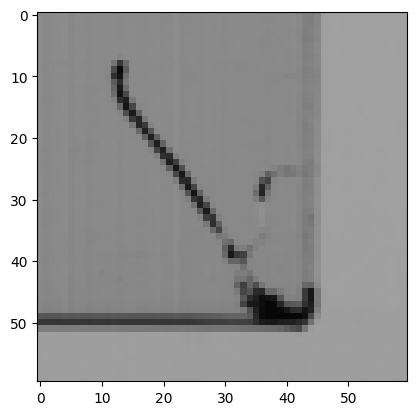

In [12]:
ex = resize_image(cv2.imread(images_dict['break'][0]), 'break', 60)
print(ex.shape)
plt.imshow(ex)

In [13]:
def preprocess_images(dict, index, size):
    for key in dict.keys():
        dict[key] = [img[:index] + '/' + img[index + 1:] for img in dict[key]]
        dict[key] = [aug for img in dict[key] for aug in augment_image(cv2.imread(img))]
        dict[key] = [resize_image(img, key, size) for img in dict[key]]
    
    return dict

In [14]:
def extend_target_classes(images_classes, n):
    target_classes = []
    for cls in images_classes:
        target_classes.extend([cls] * n)
    
    return target_classes

In [15]:
images_dict = preprocess_images(images_dict, 11, 60)
target_classes = extend_target_classes(images_classes, 4)

# for key in images_dict.keys():
#     images_dict[key] = [img[:11] + '/' + img[12:] for img in images_dict[key]]
#     images_dict[key] = [aug for img in images_dict[key] for aug in augment_image(cv2.imread(img))]
#     images_dict[key] = [resize_image(img, key, 60) for img in images_dict[key]]

# for key in masks_dict.keys():
#     masks_dict[key] = [img[:13] + '/' + img[14:] for img in masks_dict[key]]
#     masks_dict[key] = [aug for img in masks_dict[key] for aug in augment_image(cv2.imread(img))]
#     masks_dict[key] = [resize_image(img, key, 60) for img in masks_dict[key]]

# target_classes = []
# for cls in images_classes:
#     target_classes.extend([cls] * 4)

In [16]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    print('K:',K)

    for cls in K:
        datax_cls = np.random.permutation(datax[cls])[:(n_support + n_query)]
        sample.append(datax_cls)

    sample = np.array(sample)
    sample = torch.from_numpy(sample)

    sample = sample.permute(0, 1, 4, 2, 3)

    return({
        'images': sample,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query,
        'classes': list(K)
    })

In [17]:
sample_example = extract_sample(6, 4, 4, images_dict, images_classes)
sample_example['images'].shape, sample_example

K: ['mark' 'scratch' 'break' 'bubble' 'point' 'dirt']


(torch.Size([6, 8, 3, 60, 60]),
 {'images': tensor([[[[[131, 128, 129,  ..., 131, 130, 131],
             [129, 130, 130,  ..., 130, 130, 131],
             [129, 130, 131,  ..., 133, 130, 132],
             ...,
             [132, 132, 130,  ..., 131, 132, 131],
             [133, 130, 129,  ..., 133, 132, 131],
             [132, 130, 128,  ..., 128, 123, 129]],
  
            [[131, 128, 129,  ..., 131, 130, 131],
             [129, 130, 130,  ..., 130, 130, 131],
             [129, 130, 131,  ..., 133, 130, 132],
             ...,
             [132, 132, 130,  ..., 131, 132, 131],
             [133, 130, 129,  ..., 133, 132, 131],
             [132, 130, 128,  ..., 128, 123, 129]],
  
            [[131, 128, 129,  ..., 131, 130, 131],
             [129, 130, 130,  ..., 130, 130, 131],
             [129, 130, 131,  ..., 133, 130, 132],
             ...,
             [132, 132, 130,  ..., 131, 132, 131],
             [133, 130, 129,  ..., 133, 132, 131],
             [132, 130, 128, 

In [18]:
def display_sample(sample):
    sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
    plt.figure(figsize = (16,7))
    plt.imshow(out.permute(1, 2, 0))

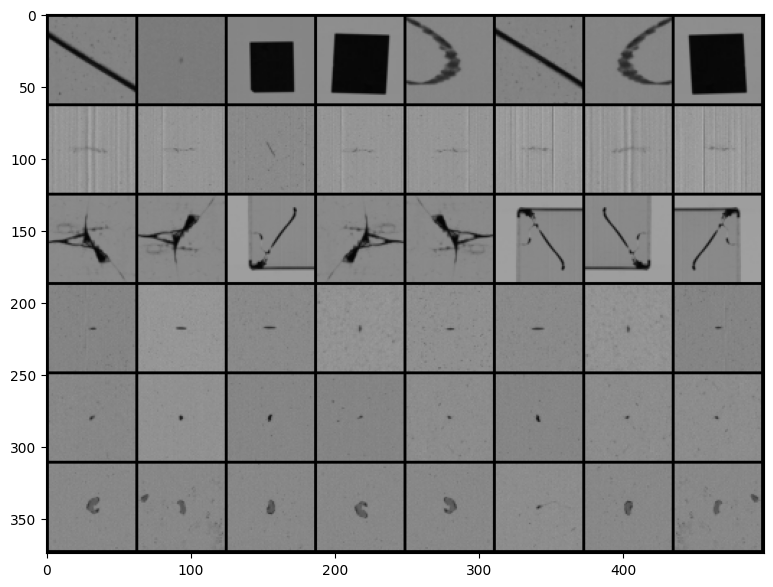

In [19]:
display_sample(sample_example['images'])

In [20]:
def euclidean_dist(x, y):
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

In [21]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        super(ProtoNet, self).__init__()
        self.encoder = encoder#.cuda()

    def set_forward_loss(self, sample, accuracy_dict):
        """
        Computes loss, accuracy and output for classification task
        Args:
            sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
        Returns:
            torch.Tensor: shape(2), loss, accuracy and y_hat
        """
        sample_images = sample['images']#.cuda()
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']
        sample_labels = sample['classes']

        x_support = sample_images[:, :n_support]
        x_query = sample_images[:, n_support:]

        #target indices are 0 ... n_way-1
        target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
        target_inds = Variable(target_inds, requires_grad=False)
        target_inds = target_inds#.cuda()

        #encode images of the support and the query set
        x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                        x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
        
        z = self.encoder.forward(x.float())
        z_dim = z.size(-1) 
        z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
        z_query = z[n_way*n_support:]

        #compute distances
        dists = euclidean_dist(z_query, z_proto)

        #compute probabilities
        log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)

        loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
        _, y_hat = log_p_y.max(2)
        acc_val = torch.eq(y_hat.squeeze(), target_inds.squeeze()).float().mean()

        accuracy_tensor = []
        for row_target, row_predicted in zip(target_inds.squeeze(), y_hat.squeeze()):
            accuracy = (row_target == row_predicted).float().mean()
            accuracy_tensor.append([accuracy])
        accuracy_tensor = torch.tensor(accuracy_tensor)

        for accuracy, cls in zip(accuracy_tensor, sample_labels):
            if cls not in accuracy_dict:
                accuracy_dict[cls] = []
            accuracy_dict[cls].append(accuracy.item())

        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc_val.item(),
            'y_hat': y_hat.squeeze(),
            'y_true': target_inds.squeeze()
        }, accuracy_dict

In [22]:
class Flatten(nn.Module):
    def __init__(self):
      super(Flatten, self).__init__()

    def forward(self, x):
      return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):
    """
    Loads the prototypical network model
    Arg:
        x_dim (tuple): dimension of input image
        hid_dim (int): dimension of hidden layers in conv blocks
        z_dim (int): dimension of embedded image
    Returns:
        Model (Class ProtoNet)
    """
    x_dim = kwargs['x_dim']
    hid_dim = kwargs['hid_dim']
    z_dim = kwargs['z_dim']

    def conv_block(in_channels, out_channels):
      return nn.Sequential(
          nn.Conv2d(in_channels, out_channels, 3, padding=1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(),
          nn.MaxPool2d(2)
          )
    
    encoder = nn.Sequential(
      conv_block(x_dim[0], hid_dim),
      conv_block(hid_dim, hid_dim),
      conv_block(hid_dim, hid_dim),
      conv_block(hid_dim, z_dim),
      Flatten()
    )
      
    return ProtoNet(encoder)

In [23]:
def  split_train_test(data, percentage = 3/4):
    train_x = {}
    test_x = {}
    for key in data.keys():
        dim = len(data[key])
        train_x[key] = data[key][:int(len(data[key])*percentage)]
        test_x[key] = data[key][-int(dim - int(dim*percentage)):]

    train_y = []
    test_y = []
    for key in data.keys():
        dim = len(data[key])
        train_y.extend([key] * int(dim*percentage))
        test_y.extend([key] * int(dim - int(dim*percentage)))

    for k in images_dict.keys():
        print(len(images_dict[k]))
    print('-----')
    for k in train_x.keys():
        print(len(train_x[k]))
    print('-----')
    for k in test_x.keys():
        print(len(test_x[k]))
    
    return train_x, train_y, test_x, test_y

In [24]:
train_x, train_y, test_x, test_y = split_train_test(images_dict)

8
20
20
20
20
20
-----
6
15
15
15
15
15
-----
2
5
5
5
5
5


# Train

In [25]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, epochs, episodes):
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0 #epochs done so far

    accuracy_dict = {}

    while epoch < epochs:
        running_loss = 0.0
        running_acc = 0.0

        for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            optimizer.zero_grad()
            loss, output, accuracy_dict = model.set_forward_loss(sample, accuracy_dict)
            running_loss += output['loss']
            running_acc += output['acc']
            loss.backward()
            optimizer.step()
            epoch_loss = running_loss / episodes
            epoch_acc = running_acc / episodes
            print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
            epoch += 1
            scheduler.step()

    return accuracy_dict

In [26]:
def print_dictionary(dictionary):
    for key, values in dictionary.items():
        average = round(sum(values) / len(values), 3)
        print(f"{key}: Average recall: {average}")

In [27]:
%%time

model = load_protonet_conv(
    x_dim=(3,60,60),
    hid_dim=64,
    z_dim=64,
)

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 3
n_support = 2
n_query = 1

epochs = 10
episodes = 50

accuracy_dict = train(model, optimizer, train_x, train_y, n_way, n_support, n_query, epochs, episodes)
print_dictionary(accuracy_dict)

C:\Users\matte\AppData\Local\Temp\ipykernel_7452\637486396.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['bubble' 'mark' 'break']
Epoch 1 -- Loss: 0.0000 Acc: 0.0200
K: ['scratch' 'dirt' 'mark']
Epoch 2 -- Loss: 0.0000 Acc: 0.0400
K: ['dirt' 'bubble' 'break']
Epoch 3 -- Loss: 0.0580 Acc: 0.0533
K: ['scratch' 'dirt' 'mark']
Epoch 4 -- Loss: 7.6893 Acc: 0.0667
K: ['point' 'scratch' 'mark']
Epoch 5 -- Loss: 8.1855 Acc: 0.0800
K: ['break' 'dirt' 'point']
Epoch 6 -- Loss: 8.6058 Acc: 0.0933
K: ['dirt' 'scratch' 'break']
Epoch 7 -- Loss: 8.6120 Acc: 0.1067
K: ['mark' 'break' 'point']
Epoch 8 -- Loss: 9.2472 Acc: 0.1200
K: ['dirt' 'break' 'bubble']
Epoch 9 -- Loss: 9.2472 Acc: 0.1400
K: ['point' 'bubble' 'dirt']
Epoch 10 -- Loss: 9.6872 Acc: 0.1467
K: ['point' 'mark' 'dirt']
Epoch 11 -- Loss: 15.8216 Acc: 0.1600
K: ['point' 'mark' 'dirt']
Epoch 12 -- Loss: 16.0378 Acc: 0.1733
K: ['break' 'scratch' 'bubble']
Epoch 13 -- Loss: 16.0378 Acc: 0.1933
K: ['bubble' 'dirt' 'point']
Epoch 14 -- Loss: 17.1371 Acc: 0.2000
K: ['dirt' 'break' 'mark']
Epoch 15 -- Loss: 17.5951 Acc: 0.2133
K: ['dirt' 'break

# Test

In [28]:
def test(model, test_x, test_y, n_way, n_support, n_query, episodes):
    running_loss = 0.0
    running_acc = 0.0

    accuracy_dict = {}

    for episode in tnrange(episodes):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, output, accuracy_dict = model.set_forward_loss(sample, accuracy_dict)
        running_loss += output['loss']
        running_acc += output['acc']
    avg_loss = running_loss / episodes
    avg_acc = running_acc / episodes
    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

    return accuracy_dict

In [29]:
n_way = 3
n_support = 1
n_query = 1

episodes = 50

accuracy_dict = test(model, test_x, test_y, n_way, n_support, n_query, episodes)
print_dictionary(accuracy_dict)

C:\Users\matte\AppData\Local\Temp\ipykernel_7452\2734032620.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['dirt' 'break' 'point']
K: ['bubble' 'break' 'point']
K: ['mark' 'dirt' 'break']
K: ['bubble' 'mark' 'break']
K: ['scratch' 'mark' 'point']
K: ['mark' 'dirt' 'point']
K: ['dirt' 'point' 'scratch']
K: ['mark' 'scratch' 'break']
K: ['break' 'bubble' 'dirt']
K: ['dirt' 'scratch' 'point']
K: ['dirt' 'bubble' 'mark']
K: ['point' 'scratch' 'bubble']
K: ['point' 'bubble' 'scratch']
K: ['scratch' 'break' 'dirt']
K: ['bubble' 'dirt' 'mark']
K: ['break' 'bubble' 'scratch']
K: ['mark' 'point' 'dirt']
K: ['break' 'bubble' 'dirt']
K: ['bubble' 'dirt' 'break']
K: ['dirt' 'point' 'mark']
K: ['bubble' 'break' 'point']
K: ['break' 'point' 'dirt']
K: ['mark' 'bubble' 'scratch']
K: ['bubble' 'mark' 'break']
K: ['dirt' 'mark' 'point']
K: ['scratch' 'bubble' 'dirt']
K: ['scratch' 'dirt' 'point']
K: ['dirt' 'break' 'point']
K: ['break' 'point' 'dirt']
K: ['bubble' 'point' 'mark']
K: ['dirt' 'bubble' 'mark']
K: ['break' 'bubble' 'point']
K: ['mark' 'bubble' 'break']
K: ['point' 'break' 'scratch']
K: ['br

# test on specific sample

In [30]:
accuracy_dict = {}

K: ['point' 'dirt' 'break']
point: Average recall: 1.0
dirt: Average recall: 0.0
break: Average recall: 1.0


{'loss': 1.0851213932037354,
 'acc': 0.6666666865348816,
 'y_hat': tensor([0, 0, 2]),
 'y_true': tensor([0, 1, 2])}

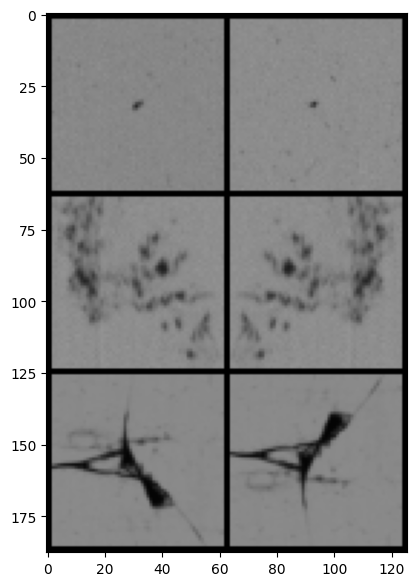

In [35]:
my_sample = extract_sample(3, 1, 1, test_x, test_y)
display_sample(my_sample['images'])
model = load_protonet_conv(
    x_dim=(3,60,60),
    hid_dim=64,
    z_dim=64,
)
my_loss, my_output, accuracy_dict = model.set_forward_loss(my_sample, accuracy_dict)
print_dictionary(accuracy_dict)
my_output

# Using default dataset + background (opt_bckg)

In [36]:
images, images_classes, images_dict = extract_images('../data/views_opt_bckg/img/')

In [37]:
classes = set(images_classes)
len(images), len(images_classes), len(classes)

(31, 31, 7)

In [38]:
classes

{'background', 'break', 'bubble', 'dirt', 'mark', 'point', 'scratch'}

In [39]:
images_dict = preprocess_images(images_dict, 26, 60)
target_classes = extend_target_classes(images_classes, 4)

In [40]:
def train_test_pipeline(images_dict, split_percentage = 3/4, 
                        train_n_way = 3, train_n_support = 2, train_n_query = 1, train_epochs = 10, train_episodes = 50, 
                        test_n_way = 3, test_n_support = 1, test_n_query = 1, test_episodes = 50):
    
    train_x, train_y, test_x, test_y = split_train_test(images_dict, split_percentage)

    model = load_protonet_conv(
        x_dim=(3,60,60),
        hid_dim=64,
        z_dim=64,
    )

    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    train_accuracy_dict = train(model, optimizer, train_x, train_y, train_n_way, train_n_support, train_n_query, train_epochs, train_episodes)

    test_accuracy_dict = test(model, test_x, test_y, test_n_way, test_n_support, test_n_query, test_episodes)

    print('----------------------------------------------')
    print('Train results')
    print_dictionary(train_accuracy_dict)
    print('----------------------------------------------')
    print('Test results')
    print_dictionary(test_accuracy_dict)

In [41]:
train_test_pipeline(images_dict)

20
8
20
20
16
20
20
-----
15
6
15
15
12
15
15
-----
5
2
5
5
4
5
5


C:\Users\matte\AppData\Local\Temp\ipykernel_7452\637486396.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['point' 'background' 'mark']
Epoch 1 -- Loss: 0.6237 Acc: 0.0133


K: ['break' 'bubble' 'point']
Epoch 2 -- Loss: 0.8749 Acc: 0.0267
K: ['break' 'bubble' 'scratch']
Epoch 3 -- Loss: 0.8749 Acc: 0.0467
K: ['break' 'bubble' 'dirt']
Epoch 4 -- Loss: 1.1668 Acc: 0.0600
K: ['background' 'bubble' 'scratch']
Epoch 5 -- Loss: 1.1668 Acc: 0.0800
K: ['dirt' 'bubble' 'scratch']
Epoch 6 -- Loss: 2.1645 Acc: 0.0933
K: ['background' 'break' 'scratch']
Epoch 7 -- Loss: 2.1654 Acc: 0.1133
K: ['point' 'dirt' 'background']
Epoch 8 -- Loss: 6.2408 Acc: 0.1133
K: ['background' 'scratch' 'point']
Epoch 9 -- Loss: 6.2408 Acc: 0.1333
K: ['bubble' 'break' 'mark']
Epoch 10 -- Loss: 8.4548 Acc: 0.1400
K: ['bubble' 'point' 'mark']
Epoch 11 -- Loss: 8.4548 Acc: 0.1600
K: ['point' 'dirt' 'break']
Epoch 12 -- Loss: 8.5211 Acc: 0.1733
K: ['scratch' 'bubble' 'background']
Epoch 13 -- Loss: 9.4291 Acc: 0.1800
K: ['mark' 'bubble' 'scratch']
Epoch 14 -- Loss: 9.4292 Acc: 0.2000
K: ['mark' 'point' 'scratch']
Epoch 15 -- Loss: 9.4292 Acc: 0.2200
K: ['background' 'point' 'bubble']
Epoch 1

C:\Users\matte\AppData\Local\Temp\ipykernel_7452\2734032620.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['bubble' 'break' 'point']
K: ['mark' 'break' 'background']
K: ['break' 'point' 'scratch']
K: ['point' 'background' 'mark']
K: ['mark' 'bubble' 'dirt']
K: ['scratch' 'point' 'break']
K: ['background' 'break' 'dirt']
K: ['background' 'mark' 'point']
K: ['point' 'bubble' 'break']
K: ['point' 'background' 'bubble']
K: ['point' 'scratch' 'mark']
K: ['scratch' 'background' 'dirt']
K: ['scratch' 'break' 'point']
K: ['scratch' 'background' 'bubble']
K: ['point' 'scratch' 'bubble']
K: ['scratch' 'point' 'background']
K: ['background' 'dirt' 'point']
K: ['scratch' 'background' 'dirt']
K: ['break' 'point' 'dirt']
K: ['bubble' 'break' 'mark']
K: ['mark' 'scratch' 'dirt']
K: ['break' 'dirt' 'point']
K: ['dirt' 'scratch' 'point']
K: ['dirt' 'bubble' 'scratch']
K: ['background' 'bubble' 'point']
K: ['scratch' 'break' 'dirt']
K: ['dirt' 'scratch' 'background']
K: ['mark' 'scratch' 'bubble']
K: ['bubble' 'background' 'scratch']
K: ['dirt' 'mark' 'scratch']
K: ['break' 'bubble' 'dirt']
K: ['backgrou

# Using qplus dataset (general classes)

In [42]:
images, images_classes, images_dict = extract_images('../data/views_qplus/img/')

In [43]:
classes = set(images_classes)
len(images), len(images_classes), len(classes)

(52, 52, 11)

In [44]:
classes

{'altro',
 'break',
 'bubble',
 'coating',
 'dirt',
 'dust',
 'glass',
 'halo',
 'mark',
 'point',
 'scratch'}

In [45]:
images_dict = preprocess_images(images_dict, 23, 60)
target_classes = extend_target_classes(images_classes, 4)

In [46]:
train_test_pipeline(images_dict)

20
8
20
20
20
20
20
20
20
20
20
-----
15
6
15
15
15
15
15
15
15
15
15
-----
5
2
5
5
5
5
5
5
5
5
5


C:\Users\matte\AppData\Local\Temp\ipykernel_7452\637486396.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['break' 'scratch' 'point']
Epoch 1 -- Loss: 2.5045 Acc: 0.0133
K: ['scratch' 'bubble' 'dust']
Epoch 2 -- Loss: 2.7214 Acc: 0.0267
K: ['dirt' 'bubble' 'glass']
Epoch 3 -- Loss: 2.9953 Acc: 0.0400
K: ['glass' 'altro' 'point']
Epoch 4 -- Loss: 4.0331 Acc: 0.0533
K: ['coating' 'break' 'altro']
Epoch 5 -- Loss: 4.3302 Acc: 0.0667
K: ['bubble' 'glass' 'scratch']
Epoch 6 -- Loss: 4.9539 Acc: 0.0667
K: ['mark' 'scratch' 'dirt']
Epoch 7 -- Loss: 4.9952 Acc: 0.0733
K: ['bubble' 'mark' 'dirt']
Epoch 8 -- Loss: 4.9952 Acc: 0.0933
K: ['coating' 'halo' 'dust']
Epoch 9 -- Loss: 5.6436 Acc: 0.1067
K: ['mark' 'dust' 'glass']
Epoch 10 -- Loss: 6.0980 Acc: 0.1200
K: ['coating' 'break' 'halo']
Epoch 11 -- Loss: 6.0980 Acc: 0.1400
K: ['point' 'scratch' 'mark']
Epoch 12 -- Loss: 6.0980 Acc: 0.1600
K: ['dust' 'coating' 'break']
Epoch 13 -- Loss: 6.1345 Acc: 0.1733
K: ['bubble' 'break' 'point']
Epoch 14 -- Loss: 8.7336 Acc: 0.1867
K: ['dust' 'break' 'scratch']
Epoch 15 -- Loss: 8.7336 Acc: 0.2067
K: ['gla

C:\Users\matte\AppData\Local\Temp\ipykernel_7452\2734032620.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['bubble' 'point' 'break']
K: ['dust' 'bubble' 'mark']
K: ['bubble' 'dirt' 'dust']
K: ['mark' 'dirt' 'altro']
K: ['halo' 'bubble' 'break']
K: ['dirt' 'halo' 'dust']
K: ['coating' 'dust' 'glass']
K: ['break' 'scratch' 'mark']
K: ['dirt' 'glass' 'break']
K: ['break' 'altro' 'point']
K: ['bubble' 'point' 'dirt']
K: ['point' 'bubble' 'glass']
K: ['mark' 'scratch' 'halo']
K: ['dust' 'mark' 'bubble']
K: ['halo' 'bubble' 'point']
K: ['point' 'glass' 'mark']
K: ['break' 'bubble' 'altro']
K: ['scratch' 'break' 'coating']
K: ['scratch' 'glass' 'dust']
K: ['bubble' 'glass' 'halo']
K: ['dirt' 'bubble' 'break']
K: ['break' 'point' 'dust']
K: ['mark' 'halo' 'glass']
K: ['dirt' 'coating' 'halo']
K: ['point' 'coating' 'altro']
K: ['dust' 'halo' 'bubble']
K: ['dust' 'dirt' 'glass']
K: ['scratch' 'mark' 'point']
K: ['glass' 'scratch' 'altro']
K: ['scratch' 'point' 'coating']
K: ['halo' 'mark' 'dust']
K: ['glass' 'halo' 'scratch']
K: ['glass' 'dust' 'scratch']
K: ['glass' 'dust' 'dirt']
K: ['break' 'm